# Audio Model training
En este notebook se realizará el entrenamiento de los modelos de aprendizaje automático relacionados con el audio.
## Imports

In [1]:
from joblib import dump
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from IPython.display import clear_output

from audio_model_training import *

## Parámetros
Indicamos los parámetros del modelo que se quiere entrenar.

In [2]:
project_dir = "/home/daniel/PycharmProjects/tfg-tinyml"
saved_models_dir = f"{project_dir}/saved models/audio"
label_index_dir = f"{saved_models_dir}/label index mappings"

data_origin = EXT
clear_training_prints = False

if data_origin == MICRO:
    data_dir = f"{project_dir}/samples/microcontroller/audio/train"
    origin_name = "Micro"
    epochs = 500
    early_stopping_patience = 50

else:
    data_dir = f"{project_dir}/samples/external/audio/train"
    origin_name = "Ext"
    epochs = 250    # Por limitaciones de RAM no se pueden entrenar demasiados epochs.
    early_stopping_patience = 20

model_name = f"{origin_name}{DATA_TYPE}DataModel"

log_dir = f"{saved_models_dir}/summaries/{model_name}"
model_dir = f"{saved_models_dir}/tensorflow/{model_name}"
checkpoint_dir = f"{saved_models_dir}/tensorflow/checkpoints"
checkpoint_path = f"{checkpoint_dir}/{model_name}.hdf5"

validation_percentage = 20.

initial_learning_rate = 0.001
decay = (initial_learning_rate / epochs) * 1.5

tf.random.set_seed(SEED)
np.random.seed(SEED)
rnd.seed(SEED)

## Carga de datos
Cargamos las muestras de audio en forma de dataset. Aprovechamos para guardar la correspondencia entre labels y nombres
de clase.

Classes:
	0: no
	1: silence
	2: unknown
	3: yes
Se usarán 12924 muestras:
	- Train: 10340
	- Validation: 2584
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Ejemplos de muestras en formato waveform.


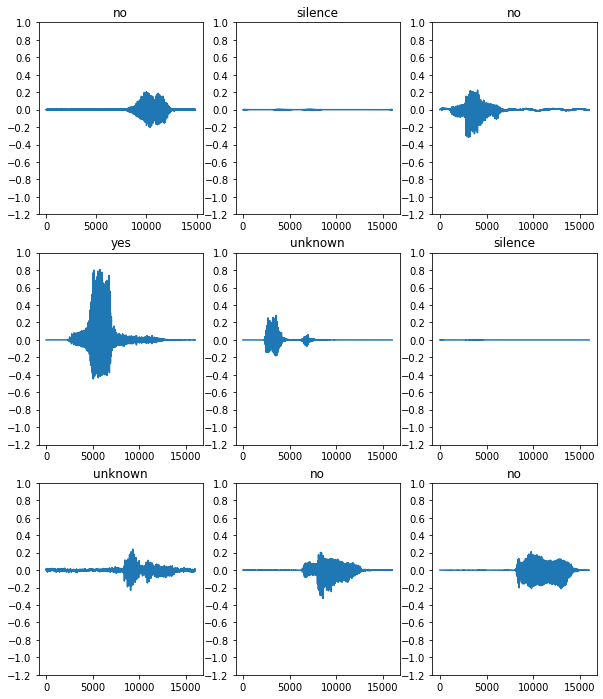

Ejemplo de conversion de waveform a espectrograma:
	- Label: no
	- Waveform shape: (14861,)
	- Spectrogram shape: (40, 49)
	
Audio playback


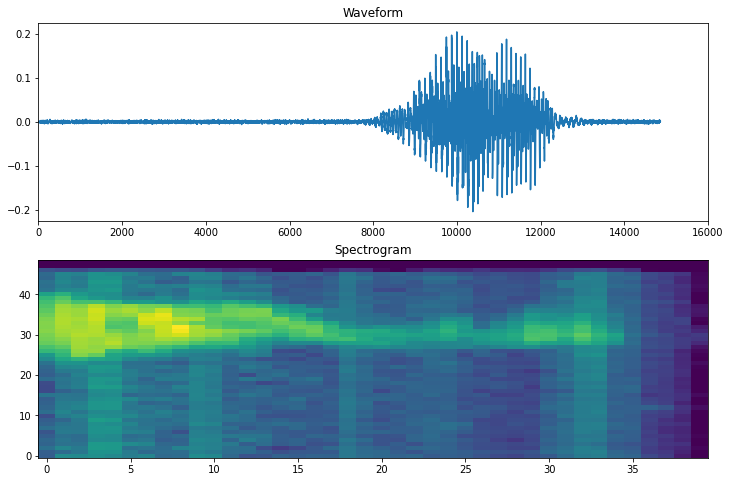

Ejemplos de muestras en formato espectrograma.


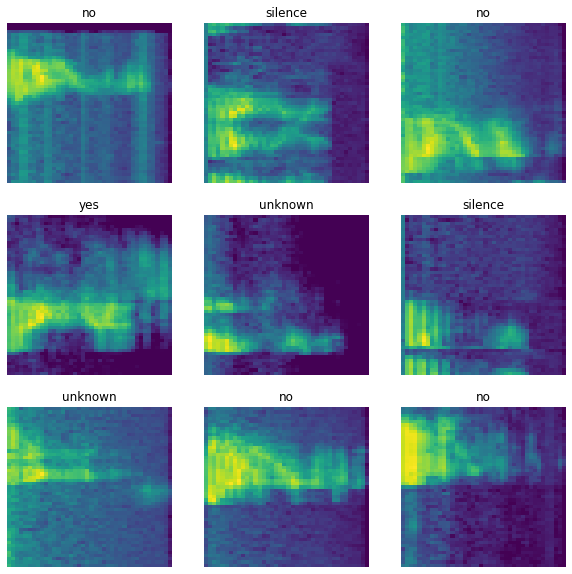

In [3]:
class_indexes = {}
class_list_text = "Classes:"
for index, name in enumerate(CLASS_NAMES):
    class_list_text += f"\n\t{index}: {name}"
    class_indexes[name] = index
print(class_list_text)
with open(f"{label_index_dir}/{model_name}.txt", "wt") as text_file:
    text_file.write(class_list_text)

dump(CLASS_NAMES, f"{label_index_dir}/{model_name}.joblib")

train_dataset, validation_dataset = get_audio_datasets(data_dir, validation_percentage, show_waveform_samples=True,
                                                       show_spectrogram_example=True, show_spectrogram_samples=True)

## Creación del modelo
Se crea el modelo que se entrenará. Visualizamos la estructura del modelo creado, donde se ve también el número de
parámetros.

Primero obtenemos las dimensiones del input a partir del dataset.

In [4]:
input_shape = None
for spectrogram, _ in train_dataset.take(1):
    input_shape = spectrogram.shape[1:]

model = get_audio_model(input_shape, model_name, train_dataset)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

model.summary()

Model: "ExtAudioDataModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 40, 49, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 17, 20, 8)         648       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 10, 8)          0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 10, 8)          0         
_________________________________________________________________
flatten (Flatten)            (None, 640)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 2564      
Total params: 3,215
Trainable params: 3,212
Non-trainable params: 3
_______________________________________________

## Entrenamiento del modelo

Se entrena el modelo creado con los datos de entrenamiento y validación.

In [5]:
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, monitor='val_accuracy',
                                            mode='max', save_best_only=True, verbose=1)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)

early_stopping_callback = EarlyStopping(monitor='val_loss', verbose=1, patience=early_stopping_patience)

def lr_time_based_decay(epoch: int, lr: float) -> float:
    """
    Callback function que reduce el learning rate conforme avanza el entrenamiento.
    Args:
        epoch:  int que representa el epoch del entrenamiento que se va a realizar a continuación.
        lr:     float con el learning rate del último epoch.

    Returns:
        float con el nuevo learning rate
    """
    return lr * 1 / (1 + decay * epoch)

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[tensorboard_callback, LearningRateScheduler(lr_time_based_decay, verbose=1), early_stopping_callback,
               model_checkpoint_callback],
)

model.load_weights(checkpoint_path)

if clear_training_prints:
    clear_output()
    print("Entrenamiento finalizado.")

Epoch 1/250

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
324/324 [==============================] - 17s 52ms/step - loss: 0.7579 - accuracy: 0.6789 - val_loss: 0.4911 - val_accuracy: 0.8057

## Visualización de historial de entrenamiento

Se visualiza accuracy y loss de training y validation.

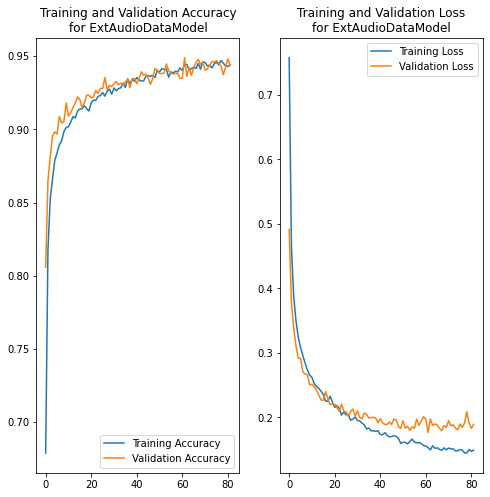

In [6]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title(f"Training and Validation Accuracy\nfor {model_name}")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title(f"Training and Validation Loss\nfor {model_name}")

plt.savefig(f"{log_dir}/{model_name}_training_data.jpg")

plt.show()

## Guardar modelo
Guardamos el modelo entrenado para poder reutilizarlo en el futuro.

In [7]:
tf.keras.models.save_model(model, model_dir)

INFO:tensorflow:Assets written to: /home/daniel/PycharmProjects/tfg-tinyml/saved models/audio/tensorflow/ExtAudioDataModel/assets
